# Linear Inverted Pendulum with Wall, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import HybridModelPredictiveController
from pympc.approximated_controller import ApproximatedHybridModelPredictiveController, FeasibleSetLibrary, upload_FeasibleSetLibrary
from pympc.geometry.polytope import Polytope

# Dynamics

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$. The pendulum is allowed to impact with an elastic wall (with stiffness $k$) placed at distance $d$ from the vertical line passing trough the hinge.

In [3]:
m = 1.
l = 1.
g = 10.
k = 1000.
d = .1
t_s = .01

We express the linearized dynamics in PieceWise Affine (PWA) form:
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u + c_1, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_1 = 
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \ x_1 \leq d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}

\begin{equation}
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ | \ x_1 > d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}


The discrete-time PWA system can be defined from its continuous-time representation setting a sampling time $t_s$.

In [4]:
# discretization method
method = 'explicit_euler'

# dynamics n.1
A_1 = np.array([[0., 1.],[g/l, 0.]])
B_1 = np.array([[0.],[1/(m*l**2.)]])
c_1 = np.array([[0.],[0.]])
S_1 = ds.AffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.2
A_2 = np.array([[0., 1.],[g/l-k/m, 0.]])
B_2 = B_1
c_2 = np.array([[0.],[k*d/(m*l)]])
S_2 = ds.AffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_1, S_2]

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state domain n.1
x_max_1 = np.array([[d/l], [1.]])
x_min_1 = -np.array([[d/l*1.2],[x_max_1[1,0]]])
X_1 = Polytope.from_bounds(x_min_1, x_max_1)
X_1.assemble()

# state domain n.2
x_min_2 = np.array([[x_max_1[0,0]], [x_min_1[1,0]]])
x_max_2 = -x_min_1
X_2 = Polytope.from_bounds(x_min_2, x_max_2)
X_2.assemble()

# list of state domains
X = [X_1, X_2]

# input domain
u_max = np.array([[4.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*2

We can now define the PWA system.

In [6]:
pwa_sys = ds.PieceWiseAffineSystem.from_orthogonal_domains(S, X, U)

# MPC controller

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
\begin{cases}
A_1 x_k + B_1 u_k + c_1, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_1, \\
A_2 x_k + B_2 u_k + c_2, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_2,
\end{cases}, \\
& (x_k, u_k) \in \mathcal D_1 \cup \mathcal D_2, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [22]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[0].A, S[0].B, Q, R)
X_N = ds.moas_closed_loop_from_orthogonal_domains(S[0].A, S[0].B, K, X[0], U[0])

# hybrid controller
gurobi_parameters = {'OutputFlag': False}
controller = HybridModelPredictiveController(pwa_sys, N, objective_norm, Q, R, P, X_N, gurobi_parameters)

Computation of Maximal Invariant Constraint-Admissible Set started.
Determinedness index: 23, Convergence index: -8.2567687914e-05, Number of facets: 120.                
Maximal Invariant Constraint-Admissible Set found.
Removing redundant facets ... minimal facets are 45.


We can now simulate the closed-loop dynamics startion from the initial state $x_0$.

In [8]:
N_sim = 100
x_0 = np.array([[.05],[.52]])
u = []
x = [x_0]
for k in range(N_sim):
    print('Time step ' + str(k) + '.\r'),
    u.append(controller.feedback(x[k]))
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

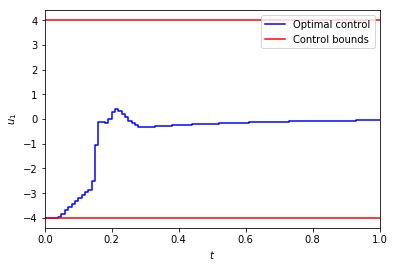

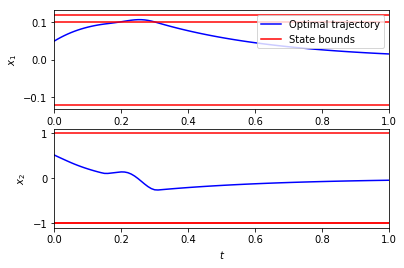

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

# Approximate MPC controller

Construction of the library

In [23]:
from pympc.approximated_controller import shift_mode_sequence
mode_sequences = [(0,)*N]
mode_types = [(0,)*i + (1,)*(N-i) for i in range(N+1)]
for mode in mode_types:
    mode_sequences.append(mode)
    mode_sequences += shift_mode_sequence(mode, 0)
mode_sequences = list(set(mode_sequences))
print len(mode_sequences)

56


In [24]:
start = (1,)
for ms in mode_sequences:
    if ms[:len(start)] == start:
        print ms

(1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
(1, 1, 1, 1, 1, 1, 1, 0, 0, 0)
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
(1, 1, 1, 1, 1, 1, 1, 1, 1, 0)
(1, 1, 1, 0, 0, 0, 0, 0, 0, 0)
(1, 1, 1, 1, 1, 1, 0, 0, 0, 0)
(1, 1, 1, 1, 1, 0, 0, 0, 0, 0)
(1, 1, 1, 1, 1, 1, 1, 1, 0, 0)
(1, 1, 0, 0, 0, 0, 0, 0, 0, 0)


In [25]:
from pympc.mode_sequence_tree import plot_mode_sequence_tree
plot_mode_sequence_tree(mode_sequences)


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0222580432892 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 1.999900e-02.
Projection derived 0.00845193862915 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***



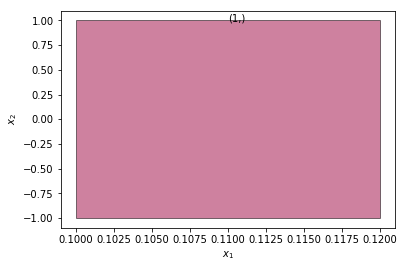


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0241048336029 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 1.286987e-02.
Projection derived 0.0163779258728 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 3, vertices found so far 3, length of the last inflation nan.
Projection derived 0.00675582885742 seconds: number of

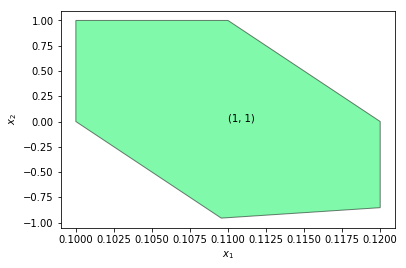


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 9, vertices found so far 9, length of the last inflation 1.348779e-04.
Projection derived 0.041445016861 seconds: number of facets is 9, number of vertices is 9.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 9, vertices found so far 9, length of the last inflation 1.128042e-04.
Projection derived 0.0553500652313 seconds: number of facets is 9, number of vertices is 9.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0257241725922 seconds: nu

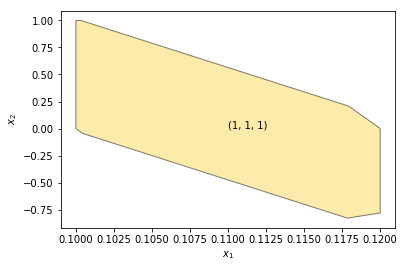


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 7, vertices found so far 7, length of the last inflation 2.374443e-04.
Projection derived 0.0297501087189 seconds: number of facets is 7, number of vertices is 7.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 8, vertices found so far 8, length of the last inflation 2.499700e-04.
Projection derived 0.0390980243683 seconds: number of facets is 8, number of vertices is 8.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 11, vertices found so far 11, length of the last inflation 1.399843e-04.
Projection derived 0.0927472114563 seconds:

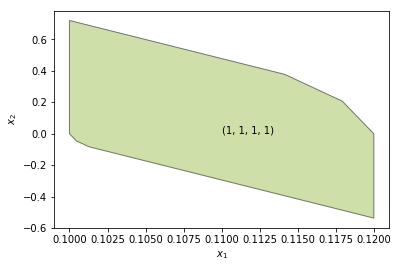


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 7, vertices found so far 7, length of the last inflation 2.374443e-04.
Projection derived 0.0457699298859 seconds: number of facets is 7, number of vertices is 7.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.499700e-04.
Projection derived 0.027932882309 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 13, vertices found so far 13, length of the last inflation 1.397469e-04.
Projection derived 0.122782945633 seconds: n

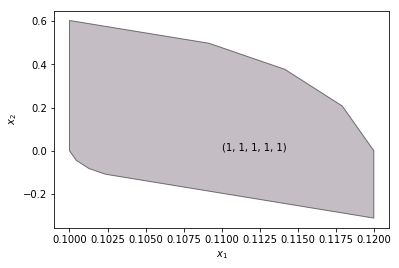


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 8, vertices found so far 8, length of the last inflation 2.374443e-04.
Projection derived 0.081503868103 seconds: number of facets is 8, number of vertices is 8.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 7, vertices found so far 7, length of the last inflation 1.210479e-03.
Projection derived 0.0517258644104 seconds: number of facets is 7, number of vertices is 7.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 11, vertices found so far 11, length of the last inflation 2.363787e-04.
Projection derived 0.103219032288 seconds: n

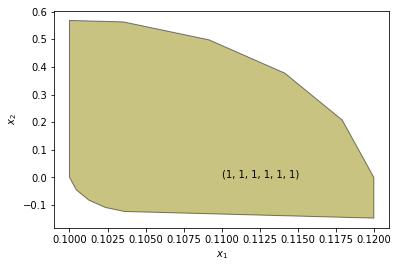


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 8, vertices found so far 8, length of the last inflation 7.746084e-04.
Projection derived 0.0569269657135 seconds: number of facets is 8, number of vertices is 8.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 8, vertices found so far 8, length of the last inflation 1.844532e-04.
Projection derived 0.0550580024719 seconds: number of facets is 8, number of vertices is 8.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 12, vertices found so far 12, length of the last inflation 2.363787e-04.
Projection derived 0.101201057434 seconds: 

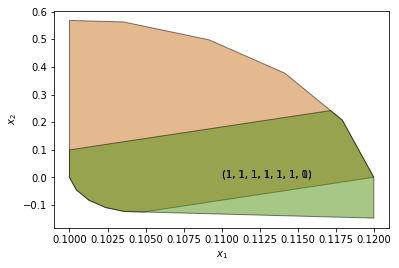


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 8, vertices found so far 8, length of the last inflation 7.803168e-04.
Projection derived 0.0632309913635 seconds: number of facets is 8, number of vertices is 8.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 8, vertices found so far 8, length of the last inflation 1.844532e-04.
Projection derived 0.078418970108 seconds: number of facets is 8, number of vertices is 8.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 11, vertices found so far 11, length of the last inflation 1.006264e-04.
Projection derived 0.0742859840393 seconds: 

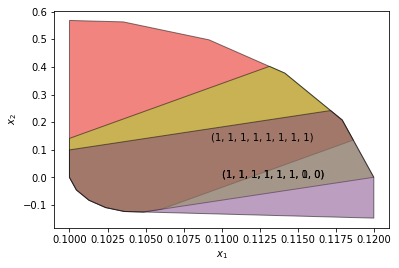


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 9, vertices found so far 9, length of the last inflation 7.825687e-04.
Projection derived 0.0807440280914 seconds: number of facets is 9, number of vertices is 9.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.499700e-04.
Projection derived 0.0672249794006 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 10, vertices found so far 10, length of the last inflation 3.999550e-04.
Projection derived 0.0940158367157 seconds:

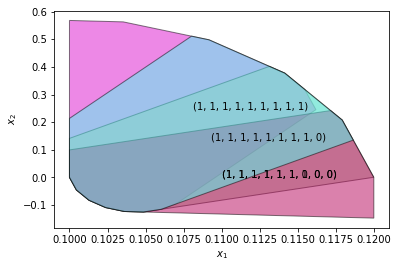


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 8, vertices found so far 8, length of the last inflation 9.392906e-04.
Projection derived 0.0731799602509 seconds: number of facets is 8, number of vertices is 8.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.499700e-04.
Projection derived 0.0993201732635 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 10, vertices found so far 10, length of the last inflation 3.999550e-04.
Projection derived 0.111587047577 seconds: 

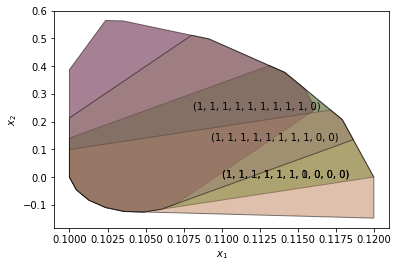

In [16]:
from pympc.geometry.convex_hull import orthogonal_projection_CHM
from copy import copy
x = np.array([[.11],[.1]])
for i in range(1,N+1):
    ms_pieces = []
    mss = []
    for ms in mode_sequences:
        if ms[:i] not in ms_pieces:
            ms_pieces.append(ms[:i])
            mss.append(ms)
    for ms in mss:
        prog = controller.condense_program(ms)
        C_u = copy(prog.C_u[:prog.row_sparsity[i], :prog.column_sparsity[i]])
        C_x = -copy(prog.C_x[:prog.row_sparsity[i], :])
        C = copy(prog.C[:prog.row_sparsity[i], :])
        p = Polytope(np.hstack((C_x, C_u)), C).assemble()
        A_pr, b_pr, _ = orthogonal_projection_CHM(p.lhs_min, p.rhs_min,[0,1])
        proj = Polytope(A_pr, b_pr).assemble()
        if proj.applies_to(x):
            plt.text(proj.center[0,0], proj.center[1,0], str(ms[:i]))
            proj.plot(facecolor=np.random.rand(3,1), alpha=.5)
    plt.show()

In [92]:

x_0 = np.array([[.095],[.3]])
ss = controller.feedforward(x_0)[2]
print ss
prog = controller.condense_program(ss)

(0, 0, 1, 1, 1, 1, 1, 1, 1, 1)



*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 15, vertices found so far 15, length of the last inflation 2.589867e-04.
Projection derived 0.212692022324 seconds: number of facets is 15, number of vertices is 15.
*** Convex Hull Method for Orthogonal Projections STOP ***



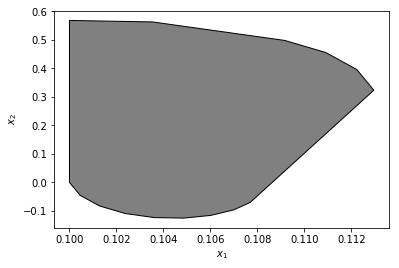

In [104]:
steps = N
ss = (1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
prog = controller.condense_program(ss)
C_u = copy(prog.C_u[:prog.row_sparsity[steps], :prog.column_sparsity[steps]])
C_x = -copy(prog.C_x[:prog.row_sparsity[steps], :])
C = copy(prog.C[:prog.row_sparsity[steps], :])
p = Polytope(np.hstack((C_x, C_u)), C).assemble()
A_pr, b_pr, _ = orthogonal_projection_CHM(p.lhs_min, p.rhs_min,[0,1])
proj = Polytope(A_pr, b_pr).assemble()
proj.plot(facecolor='gray')
plt.show()


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0136690139771 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***



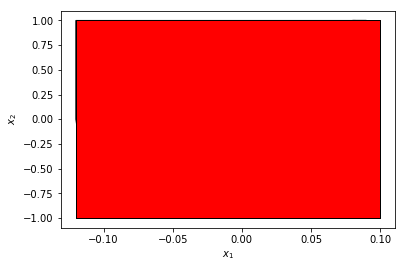


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0131959915161 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0227789878845 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***



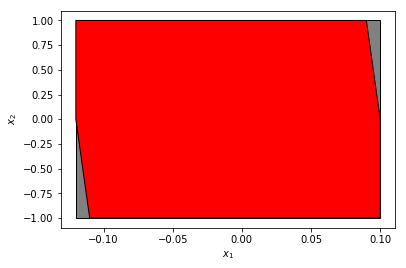


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0121259689331 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0201771259308 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0168600082397 seconds: n

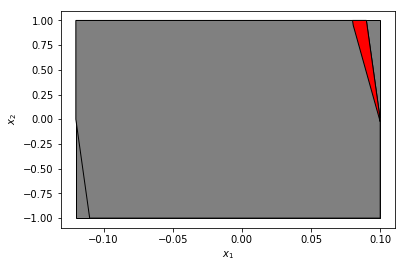


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.011577129364 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0220510959625 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0256841182709 seconds: nu

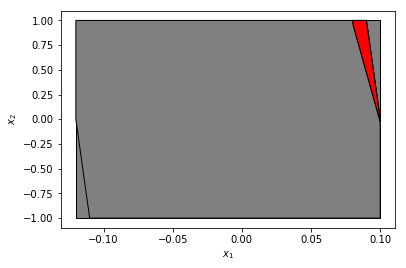


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0127940177917 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0181798934937 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.016676902771 seconds: nu

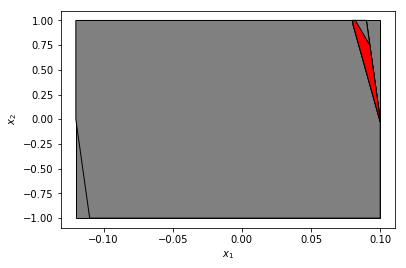


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0118670463562 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.02179479599 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0270071029663 seconds: num

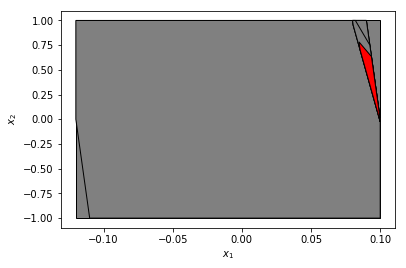


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0118329524994 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0277509689331 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0277919769287 seconds: n

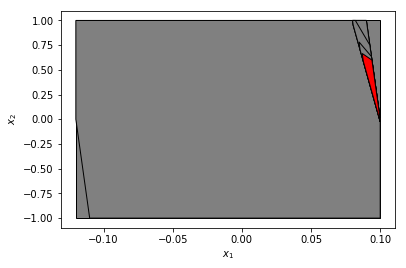


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0148169994354 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0223860740662 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0224249362946 seconds: n

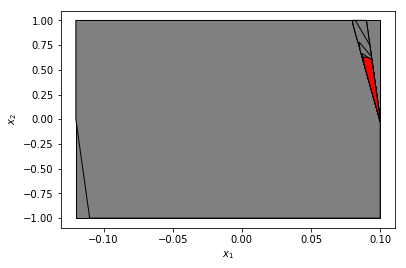


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0135350227356 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 2.050953e-01.
Projection derived 0.0264520645142 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0226140022278 seconds: n

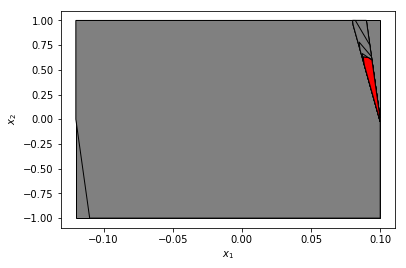


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 4, vertices found so far 4, length of the last inflation 2.186810e-01.
Projection derived 0.0135838985443 seconds: number of facets is 4, number of vertices is 4.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 6, vertices found so far 6, length of the last inflation 4.999938e-03.
Projection derived 0.0220749378204 seconds: number of facets is 6, number of vertices is 6.
*** Convex Hull Method for Orthogonal Projections STOP ***


*** Convex Hull Method for Orthogonal Projections START ***
Inner 2D simplex found.
Expansion of the inner polytope started.
Facets found so far 5, vertices found so far 5, length of the last inflation 4.569554e-04.
Projection derived 0.0219449996948 seconds: n

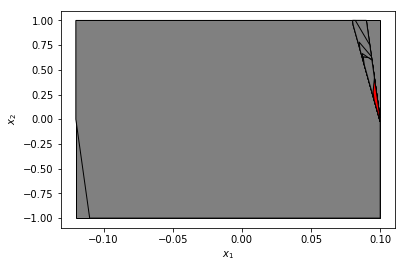

In [94]:
for NN in range(1,N+1):
    for steps in range(1, NN+1):
        C_u = copy(prog.C_u[:prog.row_sparsity[steps], :prog.column_sparsity[steps]])
        C_x = -copy(prog.C_x[:prog.row_sparsity[steps], :])
        C = copy(prog.C[:prog.row_sparsity[steps], :])
        p = Polytope(np.hstack((C_x, C_u)), C).assemble()
        A_pr, b_pr, _ = orthogonal_projection_CHM(p.lhs_min, p.rhs_min,[0,1])
        proj = Polytope(A_pr, b_pr).assemble()
        if steps == NN:
            proj.plot(facecolor='red')
        else:
            proj.plot(facecolor='gray')
        
    plt.show()